'yolo_n_baseline_SGD_lr01' 학습 설정

        - 모델: yolov8n.pt
        - 데이터셋: data_70_15_15_split.yaml
        - Epochs: 70
        - Patience: 10
        - Image Size (imgsz): 640
        - Batch Size: 16
        - Optimizer: AdamW
        - Learning Rate (lr0):0.005, 0.01, 0.03, 0.001, 0.003
        - Augmentation: False
        - Device: 0
        - Workers: 0

# 모델 실험

## 이미지 사이즈 실험

In [1]:
import os
import json
import glob
from tqdm import tqdm
from collections import defaultdict
import shutil

print("--- [Phase 1] 데이터 통합 및 정제 시작 ---")

# 경로 설정
base_dir = r"C:\Users\hyeon\Desktop\ai05-level1-project"
train_img_dir = os.path.join(base_dir, "train_images")
train_ann_dir = os.path.join(base_dir, "train_annotations")

# 모든 JSON 파일 검색
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive=True)
print(f"총 {len(json_files)}개의 JSON 어노테이션 파일 검색")

# 데이터 통합 (1489개 이미지)
master_data = defaultdict(lambda: {
    'image_path': '', 
    'width': 0, 
    'height': 0, 
    'annotations': []
})

class_to_id = {} # YOLO 학습용 ID (0, 1, 2...)
current_id = 0
processing_errors = 0

for json_path in tqdm(json_files, desc="통합 중 (Phase 1)"):
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        img_info = data['images'][0]
        img_filename = img_info['file_name']

        if not master_data[img_filename]['image_path']:
            image_path = os.path.join(train_img_dir, img_filename)
            master_data[img_filename]['image_path'] = image_path
            master_data[img_filename]['width'] = img_info['width']
            master_data[img_filename]['height'] = img_info['height']

        category_map = {cat['id']: cat['name'] for cat in data['categories']}

        for ann in data['annotations']:
            bbox = ann['bbox'] # [x, y, w, h]
            ann_cat_id = ann['category_id']
            
            if ann_cat_id not in category_map:
                processing_errors += 1
                continue

            class_name = category_map[ann_cat_id]

            if class_name not in class_to_id:
                class_to_id[class_name] = current_id
                current_id += 1
                
            class_id = class_to_id[class_name]

            master_data[img_filename]['annotations'].append({
                'class_id': class_id,
                'class_name': class_name,
                'bbox': bbox
            })
    except Exception:
        continue

print(f"총 {len(master_data)}개의 이미지 데이터 통합 완료 (정제 전)")
print(f"총 {len(class_to_id)}개의 고유 클래스 발견")

# 오류 데이터 제거 (17개 파일)
print("\nEDA 기반 오류 파일 17개 제거 시작")
iou_error_files = [
    "K-003351-018147-020238_0_2_0_2_90_000_200.png", 
    "K-003483-027733-030308-036637_0_2_0_2_90_000_200.png",
    "K-003351-020238-031863_0_2_0_2_70_000_200.png", 
    "K-003351-029667-031863_0_2_0_2_70_000_200.png",
    "K-003483-019861-025367-029667_0_2_0_2_90_000_200.png", 
    "K-002483-003743-012081-019552_0_2_0_2_90_000_200.png",
    "K-003483-019861-020238-031885_0_2_0_2_70_000_200.png", 
    "K-003351-003832-029667_0_2_0_2_90_000_200.png",
    "K-001900-016548-019607-033009_0_2_0_2_70_000_200.png"
]
oob_error_files = [
    "K-003351-016262-018357_0_2_0_2_75_000_200.png",
    "K-003544-004543-012247-016551_0_2_0_2_70_000_200.png"
]
nexium_suspect_images = [
    'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png', 
    'K-001900-010224-016551-031705_0_2_0_2_75_000_200.png',
    'K-001900-010224-016551-031705_0_2_0_2_90_000_200.png', 
    'K-001900-010224-016551-033009_0_2_0_2_70_000_200.png',
    'K-001900-010224-016551-033009_0_2_0_2_75_000_200.png', 
    'K-001900-010224-016551-033009_0_2_0_2_90_000_200.png'
]
files_to_delete = set(iou_error_files + oob_error_files + nexium_suspect_images)

deleted_count = 0
# 원본 master_data의 복사본을 순회 (순회 중 원본 삭제를 위해)
for filename in list(master_data.keys()):
    if filename in files_to_delete:
        del master_data[filename]
        deleted_count += 1

print(f"총 {deleted_count}개의 오류 파일을 master_data에서 삭제")
print(f"최종 정제된 master_data 개수: {len(master_data)}개 (1472개여야 함)")


# 최종 산출물 저장
# 정제된 1472개 데이터
clean_master_path = os.path.join(base_dir, "train_master_annotations_clean.json")
with open(clean_master_path, "w", encoding='utf-8') as f:
    json.dump(master_data, f, ensure_ascii=False, indent=4)

# 클래스 ID 맵
class_map_path = os.path.join(base_dir, "class_to_id.json")
with open(class_map_path, "w", encoding='utf-8') as f:
    json.dump(class_to_id, f, ensure_ascii=False, indent=4)

print(f"파일 저장 완료: {clean_master_path}")
print(f"파일 저장 완료: {class_map_path}")
print("--- [Phase 1] 완료 ---")

--- [Phase 1] 데이터 통합 및 정제 시작 ---
총 4526개의 JSON 어노테이션 파일 검색


통합 중 (Phase 1): 100%|██████████| 4526/4526 [00:02<00:00, 2006.89it/s]


총 1489개의 이미지 데이터 통합 완료 (정제 전)
총 73개의 고유 클래스 발견

EDA 기반 오류 파일 17개 제거 시작
총 17개의 오류 파일을 master_data에서 삭제
최종 정제된 master_data 개수: 1472개 (1472개여야 함)
파일 저장 완료: C:\Users\hyeon\Desktop\ai05-level1-project\train_master_annotations_clean.json
파일 저장 완료: C:\Users\hyeon\Desktop\ai05-level1-project\class_to_id.json
--- [Phase 1] 완료 ---


In [ ]:
import time, csv, os
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 공통 경로
base_dir = r"C:\Users\hyeon\Desktop\ai05-level1-project"
combined_dataset_dir = os.path.join(base_dir, "CombinedDataset")
yaml_path_combined = os.path.join(combined_dataset_dir, 'data_70_15_15_split.yaml')
exp_dir = os.path.join(base_dir, "Exp")
class_to_id_path = os.path.join(base_dir, "class_to_id.json")
yaml_path = yaml_path_combined

# 실험 목록 (원하는 만큼)
experiments = [
    {"name": "yolov8n_lr0005", "lr0": 0.0005},
    {"name": "yolov8n_lr001", "lr0": 0.001},
    {"name": "yolov8n_lr003", "lr0": 0.003},
    {"name": "yolov8n_lr001", "lr0": 0.01},
    {"name": "yolov8n_lr03", "lr0": 0.03},
]

summary = []  # 전체 요약 저장용

for exp in experiments:
    name = exp["name"]
    lr0 = exp["lr0"]

    class EpochTimer:
        def __init__(self):
            self.start = None
            self.times = []
        def on_train_epoch_start(self, trainer):
            self.start = time.time()
        def on_train_epoch_end(self, trainer):
            if self.start is None: return
            t = time.time() - self.start
            self.times.append(t)
            print(f"⏱ {name} | Epoch {trainer.epoch+1}: {t:.2f}s")

    timer = EpochTimer()
    model = YOLO("yolov8n.pt")
    model.add_callback("on_train_epoch_start", timer.on_train_epoch_start)
    model.add_callback("on_train_epoch_end",   timer.on_train_epoch_end)

    start = time.time()
    results = model.train(
        data=yaml_path,
        epochs=70,
        imgsz=640,
        batch=16,
        device=0,
        project=exp_dir,
        name=name,
        optimizer="AdamW",
        lr0=lr0,
        workers=0
    )
    total_min = (time.time() - start) / 60
    summary.append({"experiment": name, "total_min": round(total_min, 2)})

    # --- 실험별 개별 CSV 저장 ---
    csv_path = os.path.join(exp_dir, f"{name}_epoch_times.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "time_sec"])
        for i, t in enumerate(timer.times, start=1):
            writer.writerow([i, round(t, 2)])
    print(f"✅ {name} epoch별 시간 기록 저장 완료: {csv_path}")

# --- 전체 요약 저장 ---
summary_path = os.path.join(exp_dir, "all_experiments_time_summary.csv")
pd.DataFrame(summary).to_csv(summary_path, index=False)
print(f"📊 전체 실험 요약 저장 완료: {summary_path}")


Ultralytics 8.3.221  Python-3.11.14 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\hyeon\Desktop\ai05-level1-project\CombinedDataset\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_lr001, nbs=64, nms=False, opset=None, optimize=False, 

In [2]:
import time, csv, os
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 공통 경로
base_dir = r"C:\Users\hyeon\Desktop\ai05-level1-project"
combined_dataset_dir = os.path.join(base_dir, "CombinedDataset")
yaml_path_combined = os.path.join(combined_dataset_dir, 'data_70_15_15_split.yaml')
exp_dir = os.path.join(base_dir, "Exp")
class_to_id_path = os.path.join(base_dir, "class_to_id.json")
yaml_path = yaml_path_combined

# 실험 목록 (원하는 만큼)
experiments = [
    {"name": "yolov8n_lr01", "lr0": 0.01}
]

summary = []  # 전체 요약 저장용

for exp in experiments:
    name = exp["name"]
    lr0 = exp["lr0"]

    class EpochTimer:
        def __init__(self):
            self.start = None
            self.times = []
        def on_train_epoch_start(self, trainer):
            self.start = time.time()
        def on_train_epoch_end(self, trainer):
            if self.start is None: return
            t = time.time() - self.start
            self.times.append(t)
            print(f"⏱ {name} | Epoch {trainer.epoch+1}: {t:.2f}s")

    timer = EpochTimer()
    model = YOLO("yolov8n.pt")
    model.add_callback("on_train_epoch_start", timer.on_train_epoch_start)
    model.add_callback("on_train_epoch_end",   timer.on_train_epoch_end)

    start = time.time()
    results = model.train(
        data=yaml_path,
        epochs=70,
        imgsz=640,
        batch=16,
        device=0,
        project=exp_dir,
        name=name,
        optimizer="AdamW",
        lr0=lr0,
        workers=0
    )
    total_min = (time.time() - start) / 60
    summary.append({"experiment": name, "total_min": round(total_min, 2)})

    # --- 실험별 개별 CSV 저장 ---
    csv_path = os.path.join(exp_dir, f"{name}_epoch_times.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "time_sec"])
        for i, t in enumerate(timer.times, start=1):
            writer.writerow([i, round(t, 2)])
    print(f"✅ {name} epoch별 시간 기록 저장 완료: {csv_path}")

# --- 전체 요약 저장 ---
summary_path = os.path.join(exp_dir, "all_experiments_time_summary.csv")
pd.DataFrame(summary).to_csv(summary_path, index=False)
print(f"📊 전체 실험 요약 저장 완료: {summary_path}")


New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.221  Python-3.11.14 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\hyeon\Desktop\ai05-level1-project\CombinedDataset\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.93

c:\Users\hyeon\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
c:\Users\hyeon\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 47161 (\N{HANGUL SYLLABLE RYEONG}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
c:\Users\hyeon\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
c:\Users\hyeon\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.savefig(plot_fname, dpi=250)
c:\Users\hyeon\anaconda3\envs\codeit_project_env\Lib\site-packages\ultralytics\utils\metrics.py:582: UserWarning: G

                   all        221        839      0.933      0.937       0.99      0.986
             5mg         20         20      0.976          1      0.995      0.995
          800mg         29         29      0.961          1      0.995      0.995
          500/20mg         17         18      0.969          1      0.995      0.995
                            9          9      0.855          1      0.995      0.985
            100mg         16         16       0.85          1      0.995      0.995
         30mg         11         11      0.974          1      0.995       0.98
          ()         17         17      0.888      0.933      0.983      0.983
                      10         10      0.961          1      0.995      0.995
          500/20mg         16         16      0.979          1      0.995      0.989
                           12         12      0.953      0.917      0.979      0.979
              10mg          8          8      0.898       0.75      0.945      0.94

⚠️ yolov8n_lr01 results.csv 없음 → 건너뜀


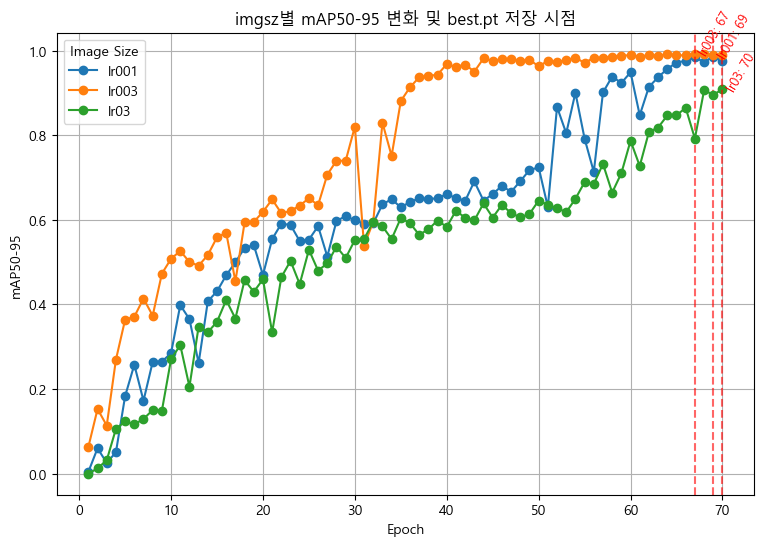

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os

base_dir = r"C:\Users\hyeon\Desktop\ai05-level1-project"
exp_dir = os.path.join(base_dir, "Exp")
exp_names = ["yolov8n_lr001", "yolov8n_lr003", "yolov8n_lr01", "yolov8n_lr03"]

plt.figure(figsize=(9,6))

for name in exp_names:
    csv_path = os.path.join(exp_dir, name, "results.csv")
    if not os.path.exists(csv_path):
        print(f"⚠️ {name} results.csv 없음 → 건너뜀")
        continue

    df = pd.read_csv(csv_path)

    # mAP50-95 컬럼 자동 탐색
    col = next((c for c in df.columns if "mAP50-95" in c), None)
    if col is None:
        print(f"⚠️ {name}: mAP50-95 관련 열을 찾지 못함.")
        continue

    # 곡선 그리기
    plt.plot(df["epoch"], df[col], marker='o', label=f"{name.split('_')[-1]}")

    # best.pt 저장 시점 찾기 (mAP50-95 최대값의 epoch)
    best_idx = df[col].idxmax()
    best_epoch = int(df.loc[best_idx, "epoch"])
    best_val = df.loc[best_idx, col]

    # 세로선 및 주석
    plt.axvline(best_epoch, color='r', linestyle='--', alpha=0.6)
    plt.text(best_epoch + 0.3, best_val - 0.01,
             f"{name.split('_')[-1]}: {best_epoch}",
             rotation=60, color='r', fontsize=9, va='bottom')

plt.title("imgsz별 mAP50-95 변화 및 best.pt 저장 시점")
plt.xlabel("Epoch")
plt.ylabel("mAP50-95")
plt.legend(title="Image Size")
plt.grid(True)
plt.show()


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='Malgun Gothic')	

# -------------------------------------------------------
# 경로 및 실험 목록
# -------------------------------------------------------
base_dir = r"C:\Users\hyeon\Desktop\ai05-level1-project"
combined_dataset_dir = os.path.join(base_dir, "CombinedDataset")
yaml_path_combined = os.path.join(combined_dataset_dir, 'data_70_15_15_split.yaml')
exp_dir = os.path.join(base_dir, "Exp")
class_to_id_path = os.path.join(base_dir, "class_to_id.json")
experiments = [
    "yolov8n_lr001",
    "yolov8n_lr003",
    "yolov8n_lr01",
    "yolov8n_lr03"
]

# -------------------------------------------------------
# 그래프 생성
# -------------------------------------------------------
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
for name in experiments:
    csv_path = os.path.join(exp_dir, f"{name}_epoch_times.csv")
    if not os.path.exists(csv_path):
        print(f"⚠️ {name}_epoch_times.csv 없음 → 건너뜀")
        continue

    # CSV 읽기
    df = pd.read_csv(csv_path)

    # epoch별 누적 시간 계산
    df = df.dropna(subset=["epoch"])  # total_time 행 제거
    df["cumulative_sec"] = df["time_sec"].cumsum()
    df["cumulative_min"] = df["cumulative_sec"] / 60

    # 그래프
    plt.plot(df["epoch"], df["cumulative_min"], marker='o', label=name)

plt.title("모델별 누적 학습 시간 비교")
plt.xlabel("Epoch")
plt.ylabel("누적 학습 시간 (분)")
plt.grid(True)
plt.legend(title="Model")

plt.subplot(1, 2, 2)
for name in experiments:
    csv_path = os.path.join(exp_dir, name, "results.csv")
    if not os.path.exists(csv_path):
        print(f"⚠️ {name} results.csv 없음 → 건너뜀")
        continue

    df = pd.read_csv(csv_path)

    # mAP50-95 컬럼 자동 탐색
    col = next((c for c in df.columns if "mAP50-95" in c), None)
    if col is None:
        print(f"⚠️ {name}: mAP50-95 관련 열을 찾지 못함.")
        continue

    # 곡선
    plt.plot(df["epoch"], df[col], marker='o', label=f"{name.split('_')[-1]}")

    # best.pt 저장 시점 찾기 (mAP50-95 최대값의 epoch)
    best_idx = df[col].idxmax()
    best_epoch = int(df.loc[best_idx, "epoch"])
    best_val = df.loc[best_idx, col]

    # 세로선 및 주석
    plt.axvline(best_epoch, color='r', linestyle='--', alpha=0.6)
    plt.text(best_epoch + 0.3, best_val - 0.01,
             f"{name.split('_')[-1]}: {best_epoch}",
             rotation=60, color='r', fontsize=9, va='bottom')

plt.title("imgsz별 mAP50-95 변화 및 best.pt 저장 시점")
plt.xlabel("Epoch")
plt.ylabel("mAP50-95")
plt.legend(title="Image Size")
plt.grid(True)
plt.legend(title="Model")
plt.show()


<Figure size 1500x600 with 2 Axes>

In [2]:
import os
import pandas as pd

exp_dir = os.path.join(base_dir, "Exp")
experiments = [
    "yolov8n_lr001",
    "yolov8n_lr003",
    "yolov8n_lr01",
    "yolov8n_lr03"
]

summary = []

for name in experiments:
    result_path = os.path.join(exp_dir, name, "results.csv")
    time_path = os.path.join(exp_dir, f"{name}_epoch_times.csv")

    if not os.path.exists(result_path):
        print(f"⚠️ {name} results.csv 없음 → 건너뜀")
        continue
    if not os.path.exists(time_path):
        print(f"⚠️ {name}_epoch_times.csv 없음 → 총 시간 계산 불가")
        total_time = None
    else:
        time_df = pd.read_csv(time_path)
        total_time = round(time_df["time_sec"].sum(), 2)

    df = pd.read_csv(result_path)

    # mAP50-95 컬럼명 탐색
    map_col = next((c for c in df.columns if "mAP50-95" in c or "metrics/mAP50-95(B)" in c), None)
    if map_col is None:
        print(f"⚠️ {name}: mAP50-95 관련 열을 찾을 수 없음.")
        continue

    best_epoch = int(df.loc[df[map_col].idxmax(), "epoch"])
    best_map = round(df[map_col].max(), 4)

    val_box = round(df.loc[df[map_col].idxmax(), "val/box_loss"], 4)
    val_cls = round(df.loc[df[map_col].idxmax(), "val/cls_loss"], 4)
    val_dfl = round(df.loc[df[map_col].idxmax(), "val/dfl_loss"], 4)
    train_box = round(df.loc[df[map_col].idxmax(), "train/box_loss"], 4)

    summary.append({
        "Model": name,
        "Best Epoch": best_epoch,
        "mAP50-95": best_map,
        "Val Box Loss": val_box,
        "Val Cls Loss": val_cls,
        "Val DFL Loss": val_dfl,
        "Train Box Loss": train_box,
        "Total Time (s)": total_time
    })

# 결과 출력
df_summary = pd.DataFrame(summary)
pd.set_option('display.precision', 4)
print("\n===== 각 모델별 요약 =====")
print(df_summary)

# CSV로 저장
csv_out = os.path.join(exp_dir, "model_summary.csv")
df_summary.to_csv



===== 각 모델별 요약 =====
           Model  Best Epoch  mAP50-95  Val Box Loss  Val Cls Loss  \
0  yolov8n_lr001          57    0.9923        0.1634        0.1737   
1  yolov8n_lr003          67    0.9925        0.1594        0.1507   
2   yolov8n_lr01          69    0.9858        0.1624        0.2312   
3   yolov8n_lr03          70    0.9081        0.1704        0.4432   

   Val DFL Loss  Train Box Loss  Total Time (s)  
0        0.7712          0.2440         2480.62  
1        0.7629          0.1757         2431.14  
2        0.7643          0.1797         3696.76  
3        0.7729          0.1969         2458.99  


<bound method NDFrame.to_csv of            Model  Best Epoch  mAP50-95  Val Box Loss  Val Cls Loss  \
0  yolov8n_lr001          57    0.9923        0.1634        0.1737   
1  yolov8n_lr003          67    0.9925        0.1594        0.1507   
2   yolov8n_lr01          69    0.9858        0.1624        0.2312   
3   yolov8n_lr03          70    0.9081        0.1704        0.4432   

   Val DFL Loss  Train Box Loss  Total Time (s)  
0        0.7712          0.2440         2480.62  
1        0.7629          0.1757         2431.14  
2        0.7643          0.1797         3696.76  
3        0.7729          0.1969         2458.99  >